# A Pseudoproxy Experiment with GraphEM and pseudoPAGES2k

**Expected time to run through: TBD mins**

This tutorial demonstrates how to get a reconstruction using GraphEM, leveraging a simple pseudoproxy dataset generated from iCESM gridded, with the realistic spatial availability but full temporal availablity of the PAGES 2k version 2 dataset.
The pseudoproxies are generated based on the original iCESM simulated surface temperature (`tas`) plus white noise with `SNR=10`.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt

## Data Preparation

(<Figure size 720x720 with 1 Axes>, {'map': <GeoAxesSubplot:>})

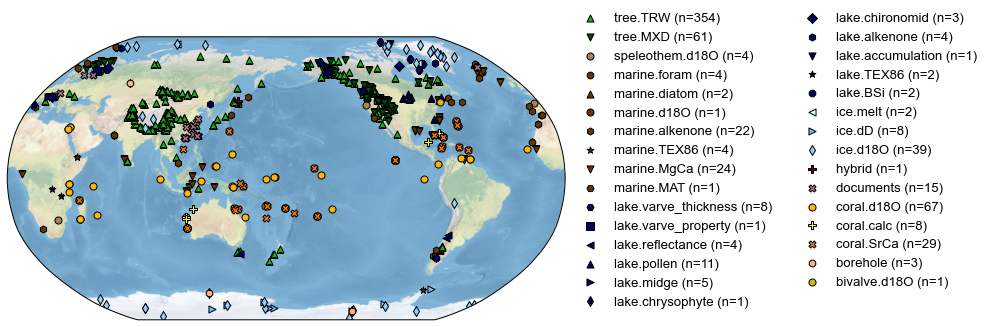

In [2]:
# load a proxy database

job = cfr.ReconJob()
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
job.proxydb.plot()

In [3]:
# filter the database
#job.proxydb = job.proxydb.filter(by='loc-square', keys=(-30, 30, 30, 250))
#fig, ax = job.proxydb.plot()

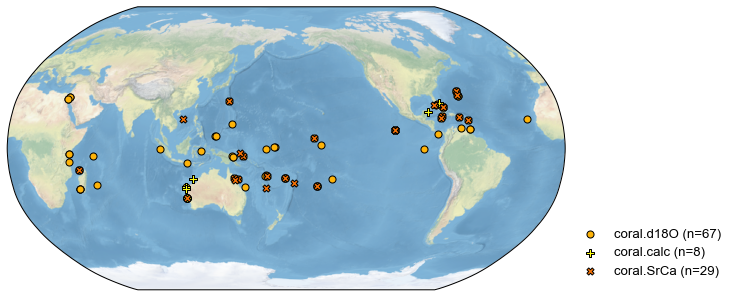

In [4]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [5]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|█████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 3652.23it/s]


In [6]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [8]:
# regrid and crop obs to make the problem size smaller
# job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 32
>>> job.configs["prior_regrid_nlon"] = 50
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


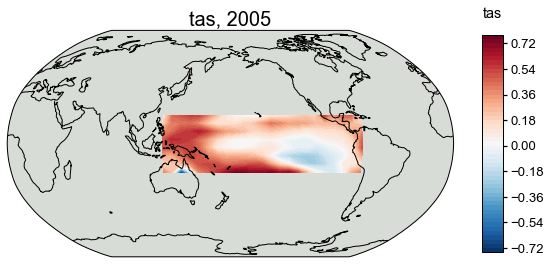

In [9]:
# annualize the observations
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [10]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 8, lon: 22)>
array([[[-0.74032895, -0.01933422,  0.06147359, ...,  0.66352944,
          0.74850286,  0.67005344],
        [ 0.31750587,  0.5778378 ,  0.64518544, ...,  0.89704427,
          0.68318284,  0.11424333],
        [ 0.40053183,  0.66181368,  0.40875361, ...,  0.36200916,
          0.03080635, -0.3999328 ],
        ...,
        [ 0.44833145,  0.36357587,  0.19014713, ..., -0.01852021,
         -0.15804461,  0.03138988],
        [ 0.75013967,  0.48704667,  0.28579122, ..., -0.07287942,
          0.3315211 ,  0.30971035],
        [ 1.08299935,  1.01469689,  1.04183424, ...,  0.05545652,
          0.15456863,  0.25373509]],

       [[-0.66601417, -0.40892799, -0.43471315, ..., -0.07151106,
         -0.00134338, -0.00211425],
        [-0.00814981, -0.14623774, -0.06503367, ...,  0.08319064,
         -0.00532564, -0.06092945],
        [ 0.07073934,  0.25106116, -0.00446787, ...,  0.02204531,
         -0.02314458,  0.02222057],
...
        [ 0.51695457,  0.68107439,  0.67203478, ...,  0.15051894,
          0.10337187,  0.28527539],
        [ 0.38660281,  0.61438818,  0.74437632, ...,  0.1242628 ,
          0.24253391,  0.50989106],
        [ 0.00559841,  0.105189  ,  0.31619696, ...,  0.45669001,
          0.494229  ,  0.47087701]],

       [[ 0.39627478,  0.20625094, -0.74604584, ..., -0.12414891,
          0.00340117,  0.26562931],
        [ 0.12202469,  0.2332395 ,  0.23810613, ..., -0.09061107,
          0.06654192,  0.0940239 ],
        [ 0.29516794,  0.28178791,  0.40905916, ..., -0.09271601,
         -0.02436461,  0.10531726],
        ...,
        [ 0.3633464 ,  0.42382227,  0.52738182, ...,  0.14286674,
          0.16299397,  0.30384674],
        [ 0.18391928,  0.40590854,  0.4192446 , ...,  0.25461563,
          0.32591307,  0.24151724],
        [ 0.06873818,  0.45355357,  0.49483162, ...,  0.31071261,
          0.46179728,  0.47332598]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 124.9 132.2 139.6 146.9 ... 257.1 264.5 271.8 279.2
  * lat      (lat) float64 -20.32 -14.52 -8.71 -2.903 2.903 8.71 14.52 20.32

The method `prep_graphem()` helps weave everything into an object that the code can work with:

In [27]:
job.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.recon_time created
>>> job.calib_time created
>>> job.calib_idx created
>>> job.temp created
>>> job.df_proxy created
>>> job.proxy created
>>> job.lonlat created


In [28]:
job.temp

array([[ 0.94455872,  0.62110351,  0.30089948, ..., -0.01308476,
         0.40807603,  0.23152266],
       [ 0.62651283, -0.20604266, -0.03311583, ...,  0.56103725,
         0.53561572,  0.43295973],
       [ 0.79936843,  0.4152735 ,  0.79006866, ...,  0.44034692,
         0.45714938,  0.26371983],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

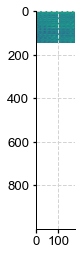

In [29]:
plt.imshow(job.temp)

In [30]:
job.df_proxy

,Ocn_065,Ocn_075,Ocn_078,Ocn_167,Ocn_091,Ocn_093,Ocn_096,Ocn_086,Ocn_101,Ocn_070,...,Ocn_090,Ocn_119,Ocn_109,Ocn_097,Ocn_159,Ocn_087,Ocn_153,Ocn_169,Ocn_071,Ocn_072
2000.0,0.117906,0.138573,0.182085,0.229045,0.300098,0.300098,0.056609,0.481311,0.699468,0.130622,...,0.627934,0.029972,0.138885,0.627934,0.029972,-0.131674,0.415641,0.323995,0.462285,0.462285
1999.0,0.491018,0.049518,0.595795,0.114631,0.376434,0.376434,-0.012054,0.322021,0.886320,0.350865,...,0.389719,0.386616,0.212224,0.389719,0.386616,0.189435,0.587975,0.429542,0.454576,0.454576
1998.0,0.449263,0.620285,0.331003,-0.710221,0.669881,0.669881,0.355502,0.194011,0.340377,0.401034,...,0.358588,0.680764,0.715996,0.358588,0.680764,1.208492,0.525448,0.066342,0.015942,0.015942
1997.0,0.203162,0.197638,0.397577,-0.058669,0.434051,0.434051,0.580503,0.313273,0.388179,0.188451,...,0.511296,0.012817,0.505579,0.511296,0.012817,-0.547594,0.074774,-0.003518,-0.219055,-0.219055
1996.0,0.711621,0.291426,0.632199,0.143895,-0.054895,-0.054895,-0.664192,-0.030944,0.308333,0.722785,...,0.268700,0.497055,-0.424533,0.268700,0.497055,0.247637,0.888607,0.429088,0.342945,0.342945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005.0,0.189849,-0.203502,-0.267335,0.186128,0.080553,0.080553,-0.190592,-0.152617,-0.247644,0.045527,...,-0.126214,-0.461959,0.005048,-0.126214,-0.461959,-0.654685,-0.108365,-0.336745,-0.441364,-0.441364
1004.0,-0.396937,-0.023028,-0.026614,0.381423,0.060887,0.060887,0.255347,0.171702,0.404180,-0.329291,...,0.120833,-0.416455,0.350750,0.120833,-0.416455,-0.355235,-0.066871,-0.152709,-0.159114,-0.159114
1003.0,-0.074143,0.186897,0.083945,0.439043,-0.002832,-0.002832,-0.364133,-0.243331,-0.202119,-0.170308,...,-0.144198,-0.067308,-0.028223,-0.144198,-0.067308,-0.067106,0.440870,0.147798,0.223871,0.223871
1002.0,-0.376911,-0.380234,-0.836313,-0.215733,-0.488090,-0.488090,-0.455390,-0.366285,-0.751944,-0.417541,...,-0.892699,-0.212252,-0.503061,-0.892699,-0.212252,0.603636,-0.293169,-0.315477,-0.374382,-0.374382


In [31]:
print(np.shape(job.temp))
print(np.shape(job.proxy))
print(np.shape(job.lonlat))

(1000, 176)
(1000, 104)
(280, 2)


## Graph estimation

In GraphEM, the selection of the covariance model used for inferring missing values is based on a [graph](http://ir.hit.edu.cn/~jguo/docs/notes/report-in-princeton-research.pdf). 
Two types of graphs are supported:
1. Neighborhood graphs
2. Empirical graphs (graphical lasso)


## 1. Neighborhood graph as initial guess

In [32]:
g0 = cfr.graphem.Graph(job.lonlat, job.temp, job.proxy)

Let us define a neighborhood graph by including only points within a cutoff_radius $R$ of each grid point or proxy locale. The location takes a bit of time the first time around as the matrix of mutual great- circle distances needs to be computed: 

In [33]:
g0.neigh_adj(cutoff_radius=1500)

Next we plot the temperature neighbors of a particular proxy to show what happened:

(<Figure size 288x288 with 1 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=1500 km)'}>)

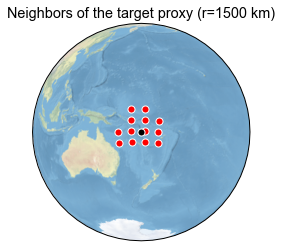

In [34]:
i = 20  # index of proxy
g0.plot_neighbors(i)

This, however, does not tell us the degree to which this proxy correlates to temperature at nerby grid points over the instrumental era. To do that, we use:

(<Figure size 360x360 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors of the target proxy (r=1500 km)'}>)

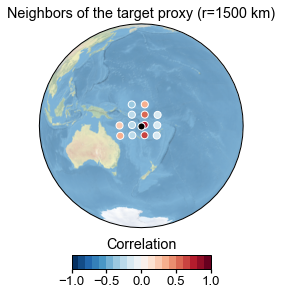

In [35]:
g0.plot_neighbors_corr(i)

This can be instructive for small proxy networks, or for debugging purposes. For a bird's eye view of the graph, we instead plot the adjacency matrix itself (dots indicate neighbors):

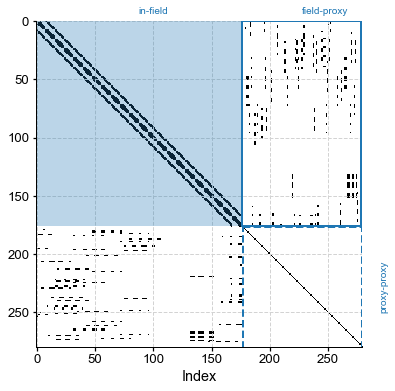

In [36]:
g0.adj_plot()

By construction, proxies are assumed conditionally independent of each other, so the proxy-proxy part of the adjacency matrix is diagonal. The climate-climate is block-diagonal, reflecting the fact that nearby indices tend to reflect nearby gridpoints, and nearby gridpoints generally have similar climates*.  There are discontinuities that happen when cycling through longitudes (0 --> 360 back to 0), which show up as abrupt breaks in the graph. The climate-proxy part is less regular, reflecting the fact that proxy locations are not uniformly spaced (unlike the grid points of the climate field). Notice how the overall matrix is very __sparse__: only a handful of of entries are non-zero (white is the main color on this plot). To be more precise, the `sparsity` property quantifies the fraction of non-zero entries:

In [37]:
g0.sparsity

[0.04857142857142857, 0.03392701048951049, 0.0]

We see that roughly 3.6% of the climate field, and 2.7% of the climate-proxy data matrix, have non-zero entries (the diagonal is excluded from this calculation, because a random variable is always conditionally dependent on itself; therefore, the proxy-proxy part of the graph has a sparsity of 0). This graph has achieved what we want: reducing the number of parameters to be estimated while computing the covariance matrix, which otherwise would be ill-conditioned. Will this suffice to yield a good estimate? Or have we thrown out the rubber duckies with the bath water and jettisoned too much information? The control knob here is the cutoff-radius. Unfortunately, there is no theoretical criterion on how to choose an appropriate one. At a minimum, it should be larger than the largest spacing between nearby grid points (which tends to at the equator). At most, it should be the scale of the planet. That leaves quite some room in between. We will first carry out a preliminary reconstruction, before refining the choice of cutoff-radius via a process called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

## Preliminary reconstruction

In [38]:
job.run_graphem?

Signature: job.run_graphem(save_path, verbose=False, **fit_kws)
Docstring:
Run the GraphEM solver, essentially the :py:meth: `GraphEM.solver.GraphEM.fit` method

Note that the arguments for :py:meth: `GraphEM.solver.GraphEM.fit` can be appended in the
argument list of this function directly. For instance, to pass a pre-calculated graph, use
`estimate_graph=False` and `graph=g.adj`, where `g` is the :py:`Graph` object.

Args:
    save_path (str): the path to save the fitting result
    verbose (bool, optional): print verbose information. Defaults to False.
    fit_kws (dict): the arguments for :py:meth: `GraphEM.solver.GraphEM.fit`

See also:
    cfr.graphem.solver.GraphEM.fit : fitting the GraphEM method
File:      ~/Documents/GitHub/cfr/cfr/reconjob.py
Type:      method


In [39]:
%%time
# need to remove G.pkl if the previous run is problematic
save_path = './results/graphem-ppe-pages2k/G.pkl'
job.run_graphem(save_path=save_path, verbose=True, estimate_graph=False, graph=g0.adj)

Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis



LinAlgError: Matrix is singular.

3.0

## Validation

In [ ]:
mask = (job.obs['tas'].time >= 1000) & (job.obs['tas'].time <= 2000)
target = job.obs['tas'].value[mask]
print(np.shape(target))

### Mean Statistics

In [ ]:
nt = np.size(ds['year'])
temp_r = job.recon.reshape((nt, -1))
V = cfr.graphem.solver.verif_stats(temp_r, target.reshape((nt, -1)), job.calib_idx)
print(V)

### Map of CE

In [ ]:
ce = cfr.utils.coefficient_efficiency(target, ds['recon'])
print(np.shape(ce))

In [ ]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
latlon_range = [0, 360, -90, 90]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']
        
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(ds['lon'].values, ds['lat'].values, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title, x=-0.05, y=0.1)

### Mean timeseries

In [ ]:
import pyleoclim as pyleo

In [ ]:
def geo_mean(field, lat):
    m = np.average(
        np.average(field, axis=-1), axis=-1, weights=np.cos(np.deg2rad(lat))
    )
    return m

In [ ]:
m_target = geo_mean(target, job.obs.fields['tas'].lat) 
ts_target = pyleo.Series(time=np.arange(1000, 2001), value=m_target)

m_recon = geo_mean(ds['recon'].values, ds['lat'].values)
ts_recon = pyleo.Series(time=ds['year'].values, value=m_recon)

fig, ax = ts_target.plot(mute=True, label='target')
ts_recon.plot(ax=ax, label='recon')
ax.plot(ds['year'].values, m_target-m_recon, label='diff')
ax.legend()
pyleo.showfig(fig)